# Image Deblurring


[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/carnotresearch/cr-sparse-evaluation/blob/master/comparison/pylops/image_deblurring.ipynb)

Please make sure that following libraries are installed to run the code in this notebook
- psutil
- cr-sparse
- pylops
- scikit-image




In [1]:
# SYSTEM INFORMATION
import psutil
import platform
un = platform.uname()
print(f"System: {un.system}, Release: {un.release}, Version: {un.version}, Machine: {un.machine}, Processor: {un.processor}")
print("Physical cores:", psutil.cpu_count(logical=False))
cpufreq = psutil.cpu_freq()
print(f"Max Frequency: {cpufreq.max:.2f}Mhz")
print(f"Min Frequency: {cpufreq.min:.2f}Mhz")
print(f"Current Frequency: {cpufreq.current:.2f}Mhz")
svmem = psutil.virtual_memory()
print(f"Total: {svmem.total / (2**30)} GB")
print(f"Available: {svmem.available / (2**30):.2f} GB")


System: Darwin, Release: 20.5.0, Version: Darwin Kernel Version 20.5.0: Sat May  8 05:10:33 PDT 2021; root:xnu-7195.121.3~9/RELEASE_X86_64, Machine: x86_64, Processor: i386
Physical cores: 4
Max Frequency: 1400.00Mhz
Min Frequency: 1400.00Mhz
Current Frequency: 1400.00Mhz
Total: 8.0 GB
Available: 2.74 GB


In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
import pylops
import numpy as np
import jax.numpy as jnp
from cr.sparse import lop
import cr.sparse as crs
import cr.sparse.vision as vision
import cr.sparse.sls as sls
import cr.sparse.geo as geo
from cr.sparse import metrics
import skimage.data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
h_jax  = vision.kernel_gaussian((15,25), (8,4))
h_np = np.array(h_jax)

(-0.5, 24.5, 14.5, -0.5)

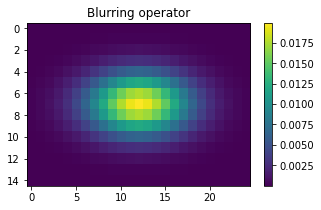

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
him = ax.imshow(h_jax)
ax.set_title('Blurring operator')
fig.colorbar(him, ax=ax)
ax.axis('tight')

In [7]:
offset = crs.arr_largest_index(h_jax)
offset

(7, 12)

(500, 480)

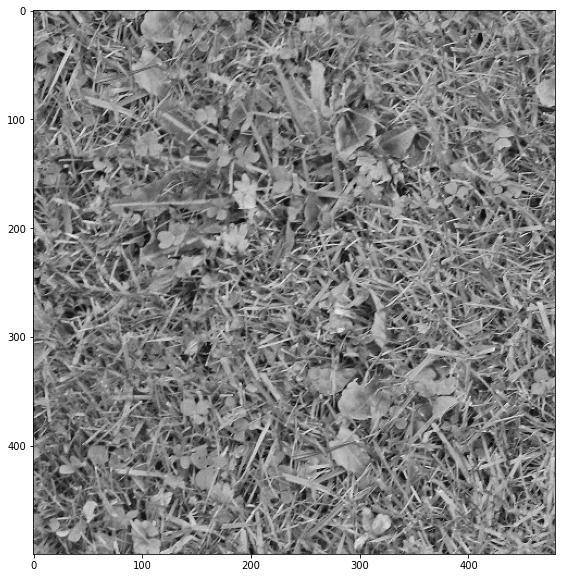

In [8]:
image_np = skimage.data.grass()
# cut the image a little bit to make use of padding later
image_np = image_np[:500, :480]
image_jax = jnp.array(image_np)
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.imshow(image_np, cmap=plt.cm.gray)
image_np.shape

In [9]:
# The blur operator using CR-Sparse
Blur_jax = lop.convolve2D(image_jax.shape, h_jax, offset=offset)
Blur_jax = lop.jit(Blur_jax)

In [10]:
Blur_np = pylops.signalprocessing.Convolve2D(image_np.size, h_np, dims=image_np.shape, offset=offset)


In [11]:
blurred_np = Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

In [12]:
blurred_jax = Blur_jax.times(image_jax)

In [13]:
np.allclose(blurred_np, blurred_jax)

True

In [14]:
blur_np_time = %timeit -o Blur_np.matvec(image_np.flatten()).reshape(image_np.shape)

8.49 ms ± 62.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
blur_jax_time = %timeit -o Blur_jax.times(image_jax)

16.7 ms ± 834 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
gain = blur_np_time.best / blur_jax_time.best
print(gain)

0.5638035259173236


In [17]:
print(metrics.peak_signal_noise_ratio(image_jax, blurred_jax), 'dB')

18.43464314401944 dB


Text(0.5, 1.0, 'After blurring')

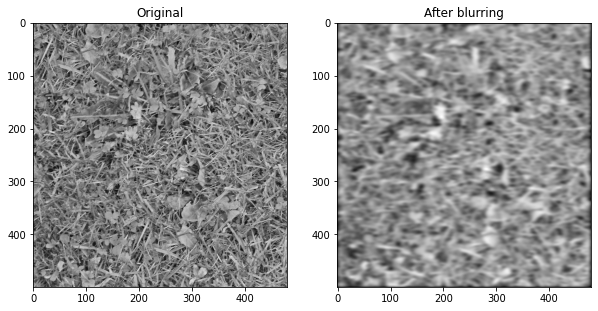

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')

In [19]:
x0 = jnp.zeros_like(blurred_jax)
sol = sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11)
deblurred_jax = sol.x
print(metrics.peak_signal_noise_ratio(image_jax, deblurred_jax), 'dB')

19.79312598449172 dB


In [20]:
print(sol)

x: (500, 480)
A_norm: 2.369799334421989
A_cond: 16.592094521926075
x_norm: 59387.28250150719
r_norm: 390.609220011111
atr_norm: 93.5208951486377
iterations: 11
n_times: 11
n_trans: 11


Text(0.5, 1.0, 'After deblurring')

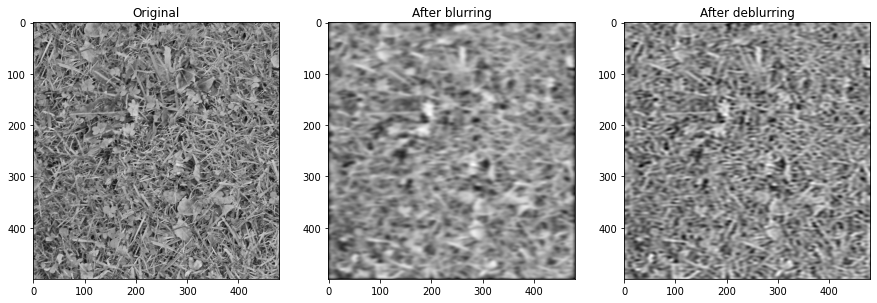

In [21]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].imshow(image_jax, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[1].imshow(blurred_jax, cmap=plt.cm.gray)
ax[1].set_title('After blurring')
ax[2].imshow(deblurred_jax, cmap=plt.cm.gray)
ax[2].set_title('After deblurring')

In [22]:
x0_np = np.array(x0).flatten()
result_np = pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)
x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var, cost= result_np
print(f'itn={itn} \n')
deblurred_np = x.reshape(image_np.shape)
print(metrics.peak_signal_noise_ratio(image_np, deblurred_np), 'dB')

itn=10 

19.79312598449172 dB


In [23]:
np.allclose(deblurred_np, deblurred_jax)

True

In [24]:
lsqr_np_time = %timeit -o pylops.optimization.solver.lsqr(Blur_np, blurred_np.flatten(), x0_np, niter=10)

237 ms ± 5.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
lsqr_jax_time = %timeit -o sls.lsqr_jit(Blur_jax, blurred_jax, x0, max_iters=11).x.block_until_ready()

438 ms ± 40.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
gain = lsqr_np_time.best / lsqr_jax_time.best
print(gain)

0.6238941940432512
